In [1]:
from stable_baselines3 import PPO, TD3
from gymnasium.envs.box2d.lunar_lander import LunarLander
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import DummyVecEnv
from dotenv import load_dotenv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
load_dotenv()

SEED = 42

In [2]:
data = []

In [3]:
class LunarLanderCollector(LunarLander):
    def __init__(self, *args, **kwargs):
        super(LunarLanderCollector, self).__init__(*args, **kwargs)
        self.collector_state = None

    def step(self, action):
        next_state, reward, terminated, truncated, info = super(LunarLanderCollector, self).step(action)
        if self.collector_state is not None:
            data.append((self.collector_state, next_state, action, reward, terminated, truncated, info))
        self.collector_state = next_state
        return next_state, reward, terminated, truncated, info

def generate_env():
    return LunarLanderCollector(render_mode='rgb_array')

check_env(generate_env())

In [ ]:
env = DummyVecEnv([generate_env] * 4)
ppo_model = PPO("MlpPolicy", env)


In [5]:
ppo_model.learn(total_timesteps=100)
ppo_model.save("lunar_lander_ppo")

In [6]:
class GymEnvDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, next_state, action, reward, done, truncated, info = self.data[idx]
        action_tensor = torch.zeros(4, dtype = torch.float32)
        action_tensor[action] = 1
        return (torch.cat([
            torch.tensor(state, dtype = torch.float32), 
            action_tensor
        ]), torch.tensor(next_state, dtype = torch.float32))

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state = SEED)
print(len(train_data), len(test_data))
train_loader = DataLoader(GymEnvDataset(train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(GymEnvDataset(test_data), batch_size=32, shuffle=False)

print(train_loader.dataset[0])

6634 1659
(tensor([ 0.3351,  0.8435,  0.9957, -0.8005, -0.2932, -0.1976,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000]), tensor([ 0.3452,  0.8264,  1.0246, -0.7616, -0.3031, -0.1983,  0.0000,  0.0000]))


In [8]:
class LunarLanderWorldModel(nn.Module):
    def __init__(self):
        super(LunarLanderWorldModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(8 + 4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )

    def forward(self, x):
        return self.network(x)

In [9]:
EPOCHS = 10
EXPERIMENT = 1

model = LunarLanderWorldModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses = []
test_losses = []

bar = tqdm(range(EPOCHS))

os.makedirs("lunar_lander_world_model", exist_ok=True)

for epoch in bar:
    losses = []
    for x, y in train_loader:
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    for x, y in test_loader:
        with torch.no_grad():
            pred = model(x)
            loss = criterion(pred, y).item()
            losses.append(loss)
    test_losses.append(sum(losses) / len(losses))
    if epoch > 0 and test_losses[-1] < min(test_losses[:-1]):
        torch.save(model.state_dict(), os.path.join("lunar_lander_world_model", f"best_model_{EXPERIMENT}.pth"))

    bar.set_description(f"Epoch {epoch + 1}/{EPOCHS} Train Loss: {train_losses[-1]} Test Loss: {test_losses[-1]}")

Epoch 10/10 Train Loss: 0.019157731681424102 Test Loss: 0.014171516032477554: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


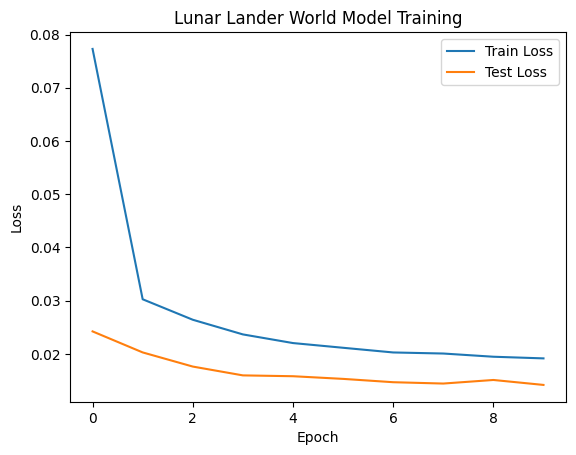

In [10]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Lunar Lander World Model Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Visualize Baseline


In [22]:
vec_env = ppo_model.get_env()
obs = vec_env.reset()

frames = []

for i in range(100):
    action, _state = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    frame = vec_env.render()
    frames.append(frame)

height, width, _ = frames[0].shape
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video = cv2.VideoWriter('lunar_lander_ppo.avi', fourcc, 20.0, (width, height))

for frame in frames:
    frame = np.array(frame, dtype = np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video.write(frame)

video.release()
